In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from stargazer.stargazer import Stargazer

from IPython.core.display import HTML

In [2]:
# Importing Excel Data
xls = "HP_data.xlsx"
df = pd.read_excel(xls)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df

/Users/kelstonchen/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,HPL,CPI,HDII,HDI,GINI_TAX,GINI_ADJ,USER_COST,UR,HSTOCK,SLOS
Date,,,,,,,,,,
1990-01-01,156088,0.66,424894,403280,0.29,0.32,9.81,7.63,5400744,38.60
1990-04-01,148973,0.66,424992,392652,0.29,0.33,12.02,7.67,5606072,38.60
1990-07-01,153420,0.67,429362,404988,0.29,0.33,12.21,8.17,5484717,32.77
1990-10-01,151196,0.68,432824,412232,0.29,0.33,11.29,9.13,5697854,38.45
1991-01-01,156088,0.69,435056,417232,0.29,0.33,7.74,10.17,5642785,26.65
...,...,...,...,...,...,...,...,...,...,...
2020-07-01,611455,1.06,1427840,1401072,0.29,0.33,4.00,10.10,10833700,7.28
2020-10-01,633690,1.07,1502905,1388204,0.29,0.33,3.22,8.80,11288929,-3.03
2021-01-01,653701,1.07,1577892,1425932,0.29,0.33,3.13,8.37,12291944,-14.95


# Error Correction Model

This is the error correction model:
$$\Delta ln (\frac {p^H_t} {Y_t}) = a_0 - a_1 [ln(\frac {p^H_{t-1}} {Y_{t-1}}) - \frac {a_2} {a_1} (r_{t-1} + \delta_{t-1} + \tau_{t-1}) - \frac {a_3} {a_1} ln H_{t-1}] + \sum \limits_{i=1}^n b_i z_t$$

However, this model can be simplified into an OLS:

$$\Delta ln (\frac {p^H_t} {Y_t}) = a_0 - a_1 ln(\frac {p^H_{t-1}} {Y_{t-1}}) - {a_2} (r_{t-1} + \delta_{t-1} + \tau_{t-1}) - {a_3} ln H_{t-1} + \sum \limits_{i=1}^n b_i z_t$$

* $\frac {p^H_t} {Y_t}$: is our house price to income ratio

* $r_t + \delta_t + \tau_t$: is our user cost, which consists of the interest rate $(r)$, depreciation rate $(\delta)$, and property tax rate $(\tau)$

* $H_{t-1}$: is our housing stock

* $\sum \limits_{i=1}^n b_i z_t$: covers all of our shock variables $(z)$ and its corresponding coefficient $(b)$

# The Variables

Here we will be creating all of the necessary variables used in the Error Correction model shown above.

In [160]:
# Describing the variables for the regression
df["lnPY"] = np.log(df["HPL"] / df["HDII"])

# Endogenous variable
df["ΔlnPY"] = df["lnPY"].diff(1)

# Equilibrium variables
df["lnPY_lag"] = df["lnPY"].shift(1)
df["UserCost_lag"] = (df["USER_COST"].shift(1)) / 100 #Dividing makes the coefficient larger
df["lnHstock_lag"] = np.log(df["HSTOCK"].shift(1))
df["UR_lag"] = df["UR"].shift(1)

# Shocks
df["ΔlnRealHDII"] = np.log(df["HDII"] / df["CPI"]).diff(1)
df["ΔlnPY_lag"] = df["lnPY_lag"].diff(1)
df["ΔlnHstock_lag"] = df["lnHstock_lag"].diff(1)
df["ΔlnGiniAdj"] = np.log(df["GINI_ADJ"]).diff(1)
df["ΔSLOS"] = (df["SLOS"].diff(1)) / 100 #Dividing makes the coefficient larger

# Variables for the estimation process
df["lnHstock"] = np.log(df["HSTOCK"])
df["ΔlnHstock"] = df["lnHstock"].diff(1)
df["ΔlnGiniAdj"] = np.log(df["GINI_ADJ"]).diff(1)
df["UserCost"] = (df["USER_COST"]) / 100

df1 = df.dropna()
# print(df1)
df_desc = df1[["ΔlnPY", "lnPY_lag", "UserCost_lag", "lnHstock_lag", "UR_lag", "ΔlnPY_lag", "ΔlnHstock_lag", "ΔlnRealHDII", "ΔlnGiniAdj", "ΔSLOS"]]
# df_desc.describe().to_html("data_table.html", classes='table table-striped text-center', justify='center')
# df_desc

## Regression with limited dates (1990Q3 - 2019Q4)

With the lack of data after the events of Covid-19 so far, we will limit the data to 2019Q4. This will be done because we do not want the extreme outcomes of Covid to dramatically affect the results of our OLS regression.

This will lead to more reliable results for our estimation.

In [161]:
# Testing the regression with only going up to 2019 Q4
limit_date = df1.loc["1990Q3":"2019Q4"]
# limit_date.to_excel("Simulation_Data.xlsx")
limit_date

,HPL,CPI,HDII,HDI,GINI_TAX,GINI_ADJ,USER_COST,UR,HSTOCK,SLOS,...,lnHstock_lag,UR_lag,ΔlnRealHDII,ΔlnPY_lag,ΔlnHstock_lag,ΔlnGiniAdj,ΔSLOS,lnHstock,ΔlnHstock,UserCost
Date,,,,,,,,,,,,,,,,,,,,,
1990-07-01,153420,0.67,429362,404988,0.29,0.33,12.21,8.17,5484717,32.77,...,15.539361,7.67,-0.004808,-0.046885,0.037314,0.0,-0.0583,15.517476,-0.021885,0.1221
1990-10-01,151196,0.68,432824,412232,0.29,0.33,11.29,9.13,5697854,38.45,...,15.517476,8.17,-0.006784,0.019184,-0.021885,0.0,0.0568,15.555600,0.038124,0.1129
1991-01-01,156088,0.69,435056,417232,0.29,0.33,7.74,10.17,5642785,26.65,...,15.555600,9.13,-0.009455,-0.022633,0.038124,0.0,-0.1180,15.545888,-0.009712,0.0774
1991-04-01,164537,0.70,444503,412040,0.29,0.33,7.18,10.33,5404971,12.57,...,15.545888,10.17,0.007093,0.026699,-0.009712,0.0,-0.1408,15.502830,-0.043059,0.0718
1991-07-01,158311,0.70,449692,420200,0.29,0.33,7.66,10.43,5681110,11.52,...,15.502830,10.33,0.011606,0.031233,-0.043059,0.0,-0.0105,15.552657,0.049828,0.0766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,574545,1.04,1268753,1244536,0.30,0.34,3.60,5.80,9711319,-15.98,...,16.116765,5.90,-0.011036,0.006287,-0.016055,0.0,-0.0504,16.088803,-0.027963,0.0360
2019-01-01,576769,1.05,1284852,1253808,0.30,0.34,3.66,5.87,9951460,-2.67,...,16.088803,5.80,0.003040,0.015690,-0.027963,0.0,0.1331,16.113230,0.024427,0.0366
2019-04-01,572767,1.05,1314230,1279508,0.30,0.34,3.09,5.60,10262513,-5.76,...,16.113230,5.87,0.022607,-0.008746,0.024427,0.0,-0.0309,16.144008,0.030778,0.0309


In [162]:
# Note: I added ΔSLOS back into this regresison, not significant but the coefficient makes sense.
reg_limit = smf.ols("ΔlnPY ~ lnPY_lag + UserCost_lag + lnHstock_lag + ΔlnPY_lag + ΔlnHstock_lag + ΔlnRealHDII + ΔlnGiniAdj + ΔSLOS + UR_lag", data=limit_date)
results_limit = reg_limit.fit()
print(results_limit.summary())

                            OLS Regression Results                            
Dep. Variable:                  ΔlnPY   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     9.836
Date:                Sun, 20 Mar 2022   Prob (F-statistic):           6.95e-11
Time:                        15:05:32   Log-Likelihood:                 362.08
No. Observations:                 118   AIC:                            -704.2
Df Residuals:                     108   BIC:                            -676.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5595      0.252      2.225

In [163]:
# reg2021 = smf.ols("ΔlnPY ~ lnPY_lag + UserCost_lag + lnHstock_lag + ΔlnPY_lag + ΔlnHstock_lag + ΔlnRealHDII + ΔlnGiniAdj + ΔSLOS + UR_lag", data=df1)
# results_2021 = reg2021.fit()
# print(results_2021.summary())

### Creating regression output tables

In [164]:
results_limit_table = Stargazer([results_limit])
# results_limit_table

In [270]:
results_limit_table.rename_covariates({"UR_lag":"Unemployment Rate (t-1)", 
                                       "UserCost_lag":"User Cost (t-1)",
                                      "lnHstock_lag":"Log Housing Stock (t-1)",
                                      "lnPY_lag":"Log House-Price-to-Income ratio (t-1)",
                                      "ΔSLOS":"Change in SLOS",
                                      "ΔlnGiniAdj":"Change in log Gini coefficient (adjusted)",
                                      "ΔlnHstock_lag":"Change in log Housing Stock (t-1)",
                                      "ΔlnPY_lag":"Change in log House-Price-to-Income ratio (t-1)",
                                      "ΔlnRealHDII":"Change in log Real Disposable Income (implied)"})

results_limit_table.dependent_variable=(" Change in log House-Price-to-Income ratio")
results_limit_table.covariate_order({"lnPY_lag":"Log House-Price-to-Income ratio (t-1)",
                                    "UserCost_lag":"User Cost (t-1)",
                                    "lnHstock_lag":"Log Housing Stock (t-1)",
                                    "UR_lag":"Unemployment Rate (t-1)",
                                    "ΔlnPY_lag":"Change in log House-Price-to-Income ratio (t-1)",
                                    "ΔlnHstock_lag":"Change in log Housing Stock (t-1)",
                                    "ΔlnRealHDII":"Change in log Real Disposable Income (implied)",
                                     "ΔlnGiniAdj":"Change in log Gini coefficient (adjusted)",
                                    "ΔSLOS":"Change in SLOS",})
results_limit_table

# open('reg_table.html', 'w').write(results_limit_table.render_html())

# Dynamic Estimation

Now lets see how the model compares to the actual data through a dynamic estimation model.

The procedure for the dynamic model is spelled out below.

<!-- 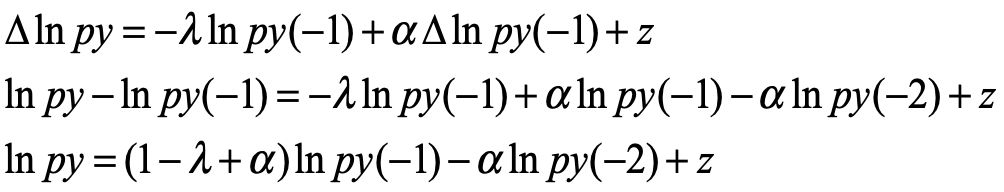 -->

 $$\Delta ln \frac{P^H_t} {Y_{t}} = -\lambda ln \frac{P^H_{t-1}} {Y_{t-1}} + \alpha \Delta ln \frac{P^H_{t-1}} {Y_{t-1}} + \sum \limits_{i=1}^n b_i z_t$$

If we let $\frac{P^H_t} {Y_{t}} = py$:

$$\Delta ln (py) = -\lambda ln (py)_{t-1} + \alpha \Delta ln (py)_{t-1} + \sum \limits_{i=1}^n b_i z_t$$

$$ln (py) - ln (py)_{t-1} = \lambda ln (py)_{t-1} + \alpha ln (py)_{t-1} - \alpha ln (py)_{t-2} + \sum \limits_{i=1}^n b_i z_t$$

 $$ ln (py) = (1 - \lambda + \alpha) ln (py)_{t-1} - \alpha ln (py)_{t-2} + \sum \limits_{i=1}^n b_i z_t$$

In [166]:
# Showing the parameters given from the OLS regression
a = results_limit.params
print(a)

Intercept        0.559525
lnPY_lag        -0.037088
UserCost_lag    -0.361029
lnHstock_lag    -0.034133
ΔlnPY_lag        0.811976
ΔlnHstock_lag    0.782664
ΔlnRealHDII     -0.670998
ΔlnGiniAdj      -0.278071
ΔSLOS           -0.004580
UR_lag          -0.003752
dtype: float64


## Generating the Dynamic Model

In [167]:
# Here we are going to create the dynamic model..
# First, the coefficients that we will use on our Dependent and lagged dependent variable in our dynamic estimation procedure
coeff = 1 + a[1] + a[4]
α1 = -a[4]

In [183]:
# Defining the function for dynamic estimation
def dynamic_est(df, UserCost, actual_data):
    
    # Creating a vector to hold the house prices
    house_prices = []
    
    # Running the dynamic estimation
    for i in range(len(df)):
        if i < actual_data:
            house_prices.append(df.iloc[i]['lnPY'])
            continue
        new_house_price = a[0]
        new_house_price += coeff * house_prices[i-1]
        new_house_price += α1 * house_prices[i-2]
        new_house_price += a[2] * df.iloc[i][UserCost]
        new_house_price += a[3] * df.iloc[i]['lnHstock']
        new_house_price += a[5] * df.iloc[i]['ΔlnHstock']
        new_house_price += a[6] * df.iloc[i]['ΔlnRealHDII']
        new_house_price += a[7] * df.iloc[i]['ΔlnGiniAdj']
        new_house_price += a[8] * df.iloc[i]['ΔSLOS']
        new_house_price += a[9] * df.iloc[i]['UR']
        house_prices.append(new_house_price)
    return house_prices

In [184]:
# Running the dynamic model created above
house_prices = dynamic_est(limit_date, 'UserCost_lag', 2)

# Predicted House Prices
pred_hp = np.log(np.exp(house_prices) * limit_date['HDII'] / limit_date['CPI'])

# Actual House Prices
actual_hp = np.log(limit_date['HPL'] / limit_date['CPI'])

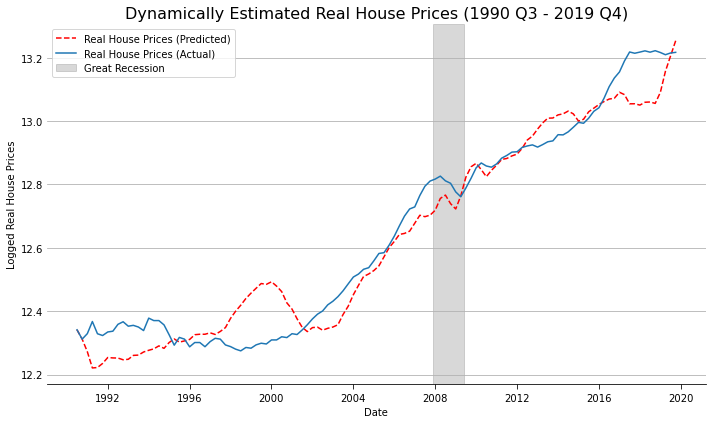

In [185]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# plotting house price lines
ax.plot(limit_date.index, pred_hp, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

# great recession shade
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3, label="Great Recession")

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)

ax.grid(axis="y")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)', fontsize='16')
plt.tight_layout()
# plt.savefig("Dynamic HPL (2019) lump", dpi=300, facecolor="white")

## Adjusting the model

Lets try to fit the model better, by starting the estimation at a later date.

The data seems to become unsettled between 1998-2003, so lets start the estimation at 1999 instead.

In [16]:
# Adjusting the Estimation so that it starts at a later date [35 == 1999-04-01]
house_prices_re = dynamic_est(limit_date, 'UserCost_lag', 35)

In [17]:
# Predicted House Prices
pred_hp_re = np.log(np.exp(house_prices_re) * limit_date['HDII'] / limit_date['CPI'])

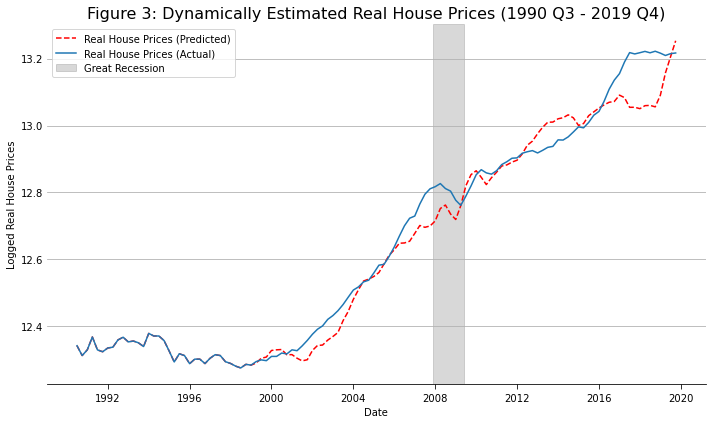

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(limit_date.index, pred_hp_re, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3, label="Great Recession")

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)

ax.grid(axis="y")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()
ax.set_title("Figure 3: Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)", fontsize='16')
plt.tight_layout()
# plt.savefig("Dynamic HPL (2019)", dpi=300, facecolor="white")

## User Cost Analysis

Lets see how an increase in user cost, either through hikes in the interest rate or a rise in property taxes, affects real house price levels in Canada. 

To do this we will look at 2 Scenarios:
   
1. An increase in the User Cost by 100 basis points (bps)

2. An increase in the User Cost by 200 bps

To show how the user cost can affect housing prices, lets assume the the central bank, or policy makers, are fully aware of the housing bubble arising, and they are stringent on doing something to stop it. In other words lets assume that the central bank will employ macro-prudential policy. In doing so, the policy rate, or property taxes, will increase in periods 2005 - 2009, and settle back to actual levels afterwards (2010-2019). 

In the first and second scenario, the interest rates will rise by 1% and 2% respectively.

In [19]:
pre = limit_date.loc['1990':'2004', 'UserCost_lag']
hike = limit_date.loc['2005':'2009', 'UserCost_lag']
post = limit_date.loc['2010':, 'UserCost_lag']

# policy hikes to stop housing bubble, then returns to normal
macro_prud = pd.concat([pre, hike+0.01, post])
macro_prud_agg = pd.concat([pre, hike+0.02, post])

limit_date['macro_prud'] = macro_prud
limit_date['macro_prud_agg'] = macro_prud_agg

/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_75019/4000690923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limit_date['macro_prud'] = macro_prud
/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_75019/4000690923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limit_date['macro_prud_agg'] = macro_prud_agg


In [20]:
est_prudent_policy = dynamic_est(limit_date, 'macro_prud', 35)
est_prudent_policy_agg = dynamic_est(limit_date, 'macro_prud_agg', 35)

pred_prudent_hp = np.log(np.exp(est_prudent_policy) * limit_date['HDII'] / limit_date['CPI'])
pred_prudent_hp_agg = np.log(np.exp(est_prudent_policy_agg) * limit_date['HDII'] / limit_date['CPI'])

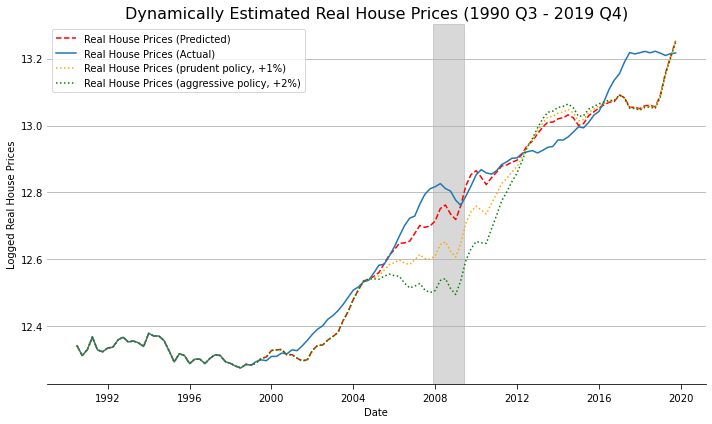

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# plotting the house prices lines
ax.plot(limit_date.index, pred_hp_re, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

ax.plot(limit_date.index, pred_prudent_hp, label="Real House Prices (prudent policy, +1%)", c='orange', linestyle=':')
ax.plot(limit_date.index, pred_prudent_hp_agg, label="Real House Prices (aggressive policy, +2%)", c='green', linestyle=':')

# great recession shade
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)


ax.grid(axis="y")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()
ax.set_title('Dynamically Estimated Real House Prices (1990 Q3 - 2019 Q4)', fontsize='16')
plt.tight_layout()

# Extending the model to 2021 Q3

In [22]:
# Re-estimating the model with the longer time frame
HPL_2021 = dynamic_est(df1, 'UserCost_lag', 35)

# Predicted and actual data points
pred_2021 = np.log(np.exp(HPL_2021) * df1['HDII'] / df1['CPI'])
actual_2021 = np.log(df1['HPL'] / df1['CPI'])

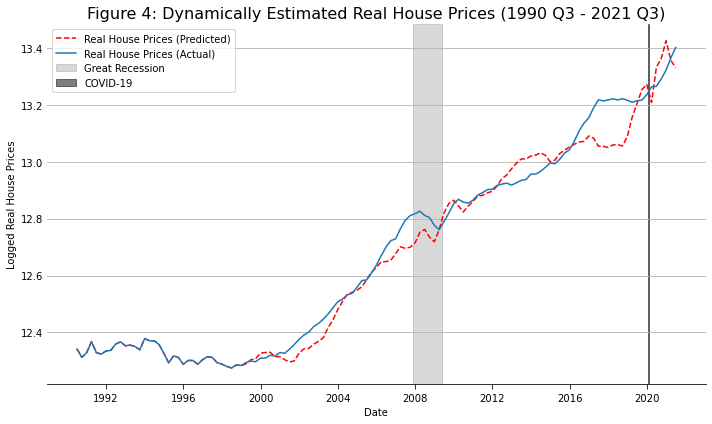

In [23]:
# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

# plotting lines
ax.plot(df1.index, pred_2021, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(df1.index, actual_2021, label="Real House Prices (Actual)")

# great recession
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3, label="Great Recession")
# COVID
ax.axvspan('2020-02-01', '2020-02-20', color='black',alpha=0.5, label="COVID-19")

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)

ax.grid(axis="y")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()
ax.set_title('Figure 4: Dynamically Estimated Real House Prices (1990 Q3 - 2021 Q3)', fontsize='16')
plt.tight_layout()

# plt.savefig("Dynamic HPL (2021)", dpi=300, facecolor="white")

## User Cost analysis including 2021

Lets see how the model looks when policy makers attack housing prices during the Great recession and during COVID-19.

In the first case, policy makers increase interest rates, or property tax rates, by 1% to impede the 2008 housing bubble, and increase interest rates by 2% at the start of 2021 to put the brakes on inflation. 

In the second case, policy makers increase rates by 100 basis points, again, but continue to lead with macro-prudential policy, though lowering rates by 50 basis points until COVID, where rates again increase by 50 basis points to 100 basis points.

In [255]:
# Creating scenarios of higher interest rates/property tax rates
pre_21 = df1.loc['1990':'2004', 'UserCost_lag']
hike_21 = df1.loc['2005':'2008', 'UserCost_lag']
post_21 = df1.loc['2009':'2020', 'UserCost_lag']
covid_policy = df1.loc['2021':, 'UserCost_lag']

# policy to attack both 2008 and the inflation period of COVID
macro_prud_21 = pd.concat([pre_21, hike_21+0.01, post_21, covid_policy+0.02])
# strict macro-prudential policy, increased user cost from 2009 until 2021
macro_prud_21_strict = pd.concat([pre_21, hike_21+0.01, post_21+0.005, covid_policy+0.01])

df1['macro_prud_21'] = macro_prud_21
df1['macro_prud_21_strict'] = macro_prud_21_strict

/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_75019/815498863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['macro_prud_21'] = macro_prud_21
/var/folders/97/wqpkg6153sbcnm16py00_sl80000gn/T/ipykernel_75019/815498863.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['macro_prud_21_strict'] = macro_prud_21_strict


In [256]:
est_policy_21 = dynamic_est(df1, 'macro_prud_21', 35)
est_policy_strict = dynamic_est(df1, 'macro_prud_21_strict', 35)

pred_prud_hp_21 = np.log(np.exp(est_policy_21) * df1['HDII'] / df1['CPI'])
pred_prud_hp_strict = np.log(np.exp(est_policy_strict) * df1['HDII'] / df1['CPI'])

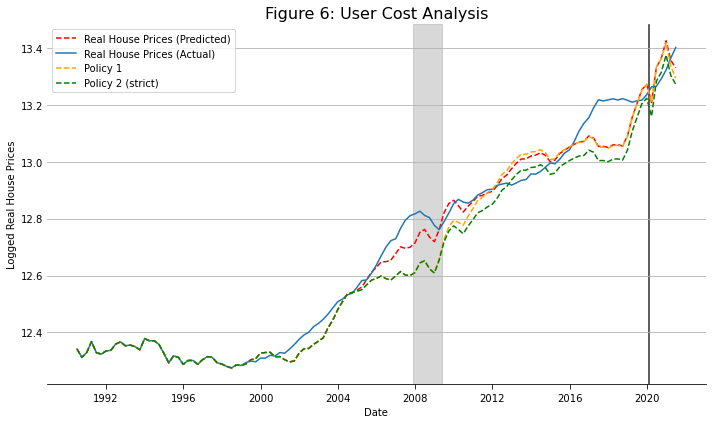

In [269]:
# Plotting 
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df1.index, pred_2021, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(df1.index, actual_2021, label="Real House Prices (Actual)")

ax.plot(df1.index, pred_prud_hp_21, label="Policy 1", c='orange', linestyle='--')
ax.plot(df1.index, pred_prud_hp_strict, label="Policy 2 (strict)", c='green', linestyle='--')

# great recession
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)
# COVID
ax.axvspan('2020-02-01', '2020-02-20', color='black',alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)

ax.grid(axis="y")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()
ax.set_title('Figure 6: User Cost Analysis', fontsize='16')
plt.tight_layout()
# plt.savefig("Dynamic HPL, (UC analysis)", dpi=300, facecolor="white")

### Explaining the Flat portion from 2017-2018

In [63]:
df_desc.loc["2017-01-01":"2019-12-01"].std()

ΔlnPY            0.017533
lnPY_lag         0.019674
UserCost_lag     0.003083
lnHstock_lag     0.025090
UR_lag           0.418536
ΔlnPY_lag        0.018052
ΔlnHstock_lag    0.022734
ΔlnRealHDII      0.009940
ΔlnGiniAdj       0.008368
ΔSLOS            0.076314
dtype: float64

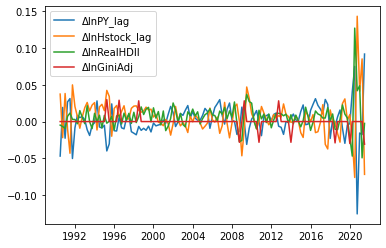

In [45]:
labels = df_desc.columns[5:9]

plt.plot(df_desc.loc[:, "ΔlnPY_lag":"ΔlnGiniAdj"], label=labels)
plt.legend()

In [46]:
df_desc.loc["2000-01-01":"2006-12-01"].std()

ΔlnPY            0.010127
lnPY_lag         0.067360
UserCost_lag     0.010479
lnHstock_lag     0.010329
UR_lag           0.448235
ΔlnPY_lag        0.010299
ΔlnHstock_lag    0.009015
ΔlnRealHDII      0.009158
ΔlnGiniAdj       0.000000
ΔSLOS            0.133177
dtype: float64

In [29]:
df_desc.describe()

,ΔlnPY,lnPY_lag,UserCost_lag,lnHstock_lag,UR_lag,ΔlnPY_lag,ΔlnHstock_lag,ΔlnRealHDII,ΔlnGiniAdj,ΔSLOS
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,0.002386,-1.036387,0.062714,15.992246,7.890480,0.001695,0.006005,0.006214,-0.000246,-0.004210
std,0.022060,0.127504,0.024459,0.192658,1.602615,0.022242,0.024588,0.017340,0.008597,0.127827
min,-0.125463,-1.253458,0.023700,15.502830,5.600000,-0.125463,-0.075947,-0.049310,-0.030772,-0.269200
25%,-0.008489,-1.133441,0.044700,15.937064,6.870000,-0.008598,-0.002885,-0.001879,0.000000,-0.058900
50%,0.001874,-1.029121,0.061400,16.037748,7.470000,0.001802,0.006060,0.007075,0.000000,-0.013600
75%,0.013556,-0.980324,0.077400,16.131044,8.770000,0.012169,0.018312,0.011731,0.000000,0.046700
max,0.091709,-0.722614,0.126200,16.324455,13.100000,0.091709,0.143076,0.126953,0.029853,0.556300


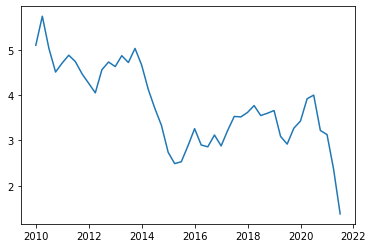

In [70]:
plt.plot(df1.loc["2010":"2021", "USER_COST"])

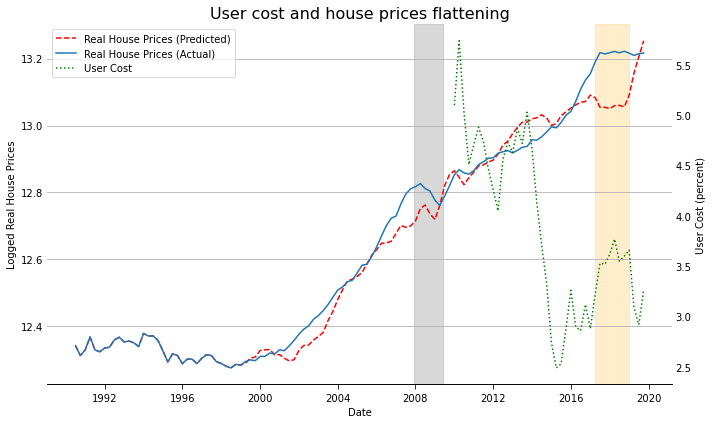

In [200]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(limit_date.index, pred_hp_re, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(limit_date.index, actual_hp, label="Real House Prices (Actual)")

ax2 = ax.twinx()
ax2.plot(limit_date.loc["2010":"2021", "USER_COST"], color="green", linestyle=":", label="User Cost")

ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3, label="Great Recession")
ax.axvspan('2017-04-01', '2019-01-01', color='orange', alpha=0.2) # flatspot

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')
ax2.set_ylabel("User Cost (percent)")

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)
ax2.tick_params(axis="y", length=0)

ax.grid(axis="y")

ax.spines[["top", "right", "left"]].set_visible(False)
ax2.spines[["top", "right", "left"]].set_visible(False)

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [l.get_label() for l in lines])

ax.set_title("User cost and house prices flattening", fontsize='16')
plt.tight_layout()
# plt.savefig("Usercost_HPL_flat", dpi=300, facecolor="white")

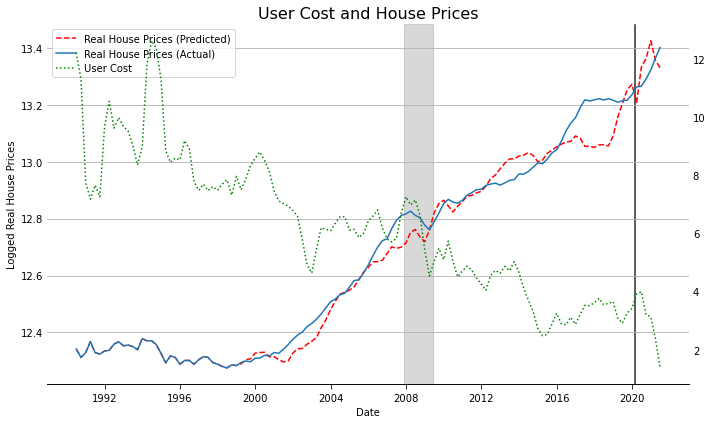

In [220]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# plotting house price lines
ax.plot(df1.index, pred_2021, label="Real House Prices (Predicted)", c='red', linestyle='--')
ax.plot(df1.index, actual_2021, label="Real House Prices (Actual)")
ax2 = ax.twinx()
ax2.plot(df1.loc[:, "USER_COST"], color="green", linestyle=":", label="User Cost")

# great recession shade
ax.axvspan('2007-12-01', '2009-06-01', color='grey', alpha=0.3)
ax.axvspan('2020-02-01', '2020-02-20', color='black',alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Logged Real House Prices')

ax.tick_params(axis="y", length=0)
ax.tick_params(axis="x", length=5)
ax2.tick_params(axis="y", length=0)

ax.grid(axis="y")

ax.spines[["top", "right", "left"]].set_visible(False)
ax2.spines[["top", "right", "left"]].set_visible(False)

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc="best")

ax.set_title("User Cost and House Prices", fontsize='16')
plt.tight_layout()
# plt.savefig("UserCost_HP_2021", dpi=300, facecolor="white")

# Impulse Response Function

In [30]:
def IRF(df, initial, shock, actual_data=2):
    
    # Creating a vector to hold the response function
    IRF = [initial, shock]
    # Running the IRF
    for i in range(len(df)):
        if i < actual_data:
            continue
        if len(IRF) < len(df):
            response = coeff * IRF[i-1] # lnPY(-1)
            response += α1 * IRF[i-2] # ΔlnPY(-2)
            IRF.append(response)
    return IRF

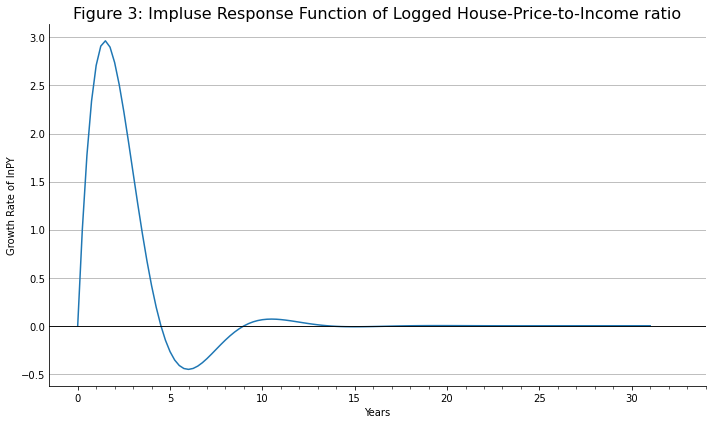

In [264]:
IRF_lnPY = np.array(IRF(df1, 0, 1))
time = np.array([i for i in range(len(df1))])

fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(time/4, IRF_lnPY, linestyle="-")
ax.axhline(0, 0, 31, linestyle="-", color='black', linewidth=0.9)

minor_ticks = np.arange(0, ax.get_xticks().max(), 1)
ax.set_xticks(minor_ticks, minor=True)
ax.tick_params(axis="x", which="minor", length=3)
ax.tick_params(axis="y", length=0)


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Years")
ax.set_ylabel("Growth Rate of lnPY")

ax.set_title("Figure 3: Impluse Response Function of Logged House-Price-to-Income ratio", fontsize='16')
plt.grid(axis="y")
plt.tight_layout()
# plt.savefig("IRF", dpi=300, facecolor="white")